In [1]:
from explainers.GNNBoundary.gnn_boundary.models.linear_gcn_classifier import LinearGCNClassifier as LinearGCNClassifier
import torch as torch

In [2]:
import numpy as np

In [3]:
model = LinearGCNClassifier( num_classes=2, node_features=1, hidden_channels=16)
model.load_state_dict(torch.load('model/report_models/counting.pt'))

<All keys matched successfully>

In [4]:
from graph_generation.NodeCountGraphs import NodeCountGraphs
import libraries.dataLoaderWrapper as DLW
dataset = DLW.GNNInterpreterLoaderWrapper(NodeCountGraphs(2000).getDataset())
mean_embeds = dataset.mean_embeddings(model)


/home/sobibence/AAU/2_semester/project/GraBaNN/libraries/dataLoaderWrapper.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obj.y = torch.tensor(obj.y, dtype=torch.long)


In [5]:
y = [data.y for data in dataset]
classes = np.unique(y)
class_indexes = []
for c in classes:
    class_indexes.append(np.where(y == c)[0])
class_indexes

[array([   0,    5,    8, ..., 1995, 1998, 1999]),
 array([   1,    2,    3,    4,    6,    7,    9,   11,   14,   18,   21,
          24,   27,   29,   30,   32,   34,   35,   36,   39,   42,   45,
          46,   47,   48,   49,   52,   54,   56,   57,   59,   61,   62,
          66,   67,   68,   70,   71,   72,   74,   77,   78,   81,   83,
          85,   88,   89,   90,   92,   94,   96,   98,  100,  103,  106,
         110,  112,  113,  116,  118,  122,  123,  126,  130,  134,  136,
         137,  138,  148,  157,  158,  160,  162,  168,  171,  177,  179,
         180,  183,  184,  185,  186,  198,  199,  202,  203,  206,  208,
         211,  219,  220,  221,  226,  228,  232,  234,  237,  241,  246,
         247,  249,  250,  253,  254,  255,  258,  259,  261,  264,  265,
         267,  269,  270,  272,  274,  275,  276,  278,  279,  283,  284,
         286,  288,  293,  294,  298,  299,  302,  303,  304,  307,  309,
         310,  318,  323,  325,  327,  328,  332,  334,  337,

In [6]:

trainers = {}

In [31]:
from explainers.gnninterpreter import *
c = 0

trainers[c] = Trainer(
            sampler=(s := GraphSampler(
                max_nodes=15,
                temperature=0.15,
                learn_node_feat=False
            )),
            discriminator=model,
            criterion=WeightedCriterion([
                dict(key="logits", criterion=ClassScoreCriterion(class_idx=c, mode='maximize'), weight=50),
                #dict(key="logits", criterion=ClassScoreCriterion(class_idx=, mode='minimize'), weight=5),
                dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[c]), weight=1),
                dict(key="logits", criterion=MeanPenalty(), weight=1),
                dict(key="omega", criterion=NormPenalty(order=1), weight=1),
                dict(key="omega", criterion=NormPenalty(order=2), weight=1),
                #dict(key="xi", criterion=NormPenalty(order=1), weight=0),
                #dict(key="xi", criterion=NormPenalty(order=2), weight=0),
                # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
                # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
                dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=2),
            ]),
            optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
            scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
            dataset=dataset,
            budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
            target_probs={c: (0.9, 1)},
            k_samples=16
        )
trainers[c].train(4000)

  0%|          | 0/4000 [00:00<?, ?it/s]

True

n=14 m=9
logits=[-7.374011993408203, 8.464366912841797]
probs=[1.3227548834038316e-07, 0.9999998807907104]


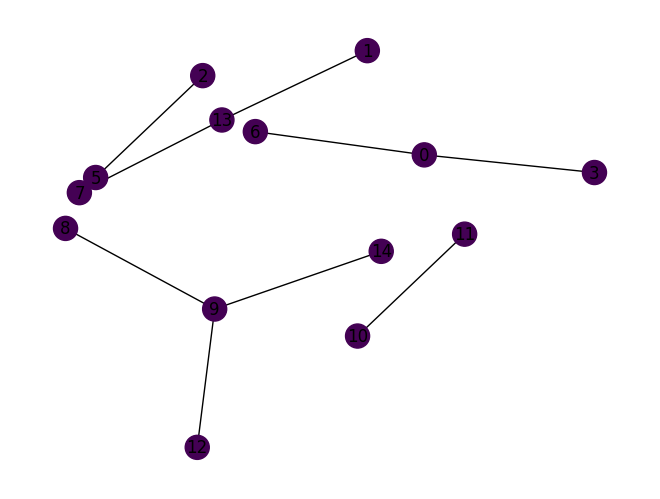

(<networkx.classes.graph.Graph at 0x7fc0f2fdf6d0>,
 {'n': 14,
  'm': 9,
  'logits': [-7.374011993408203, 8.464366912841797],
  'probs': [1.3227548834038316e-07, 0.9999998807907104]})

In [30]:
trainers[1].evaluate(threshold=0.5, show=True)

n=7 m=6
logits=[2.9348466396331787, -2.7794926166534424]
probs=[0.9967125654220581, 0.003287486033514142]


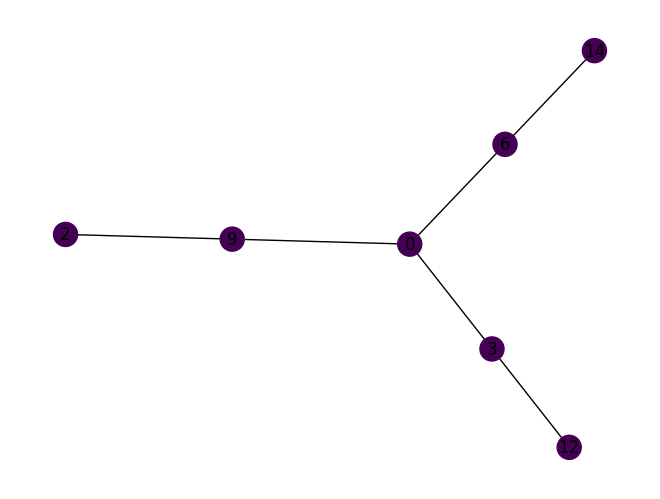

(<networkx.classes.graph.Graph at 0x7fc0f06608b0>,
 {'n': 7,
  'm': 6,
  'logits': [2.9348466396331787, -2.7794926166534424],
  'probs': [0.9967125654220581, 0.003287486033514142]})

In [32]:
trainers[0].evaluate(threshold=0.5, show=True)